(333, 250)
(1, 1, 333, 250)
(30, 1, 5, 5)


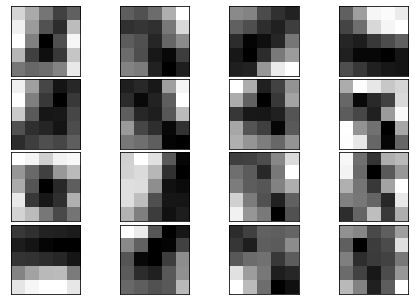

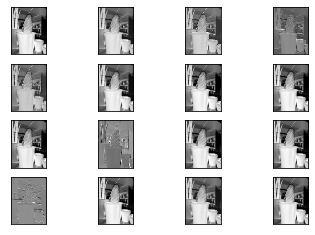

In [8]:
import sys, os
sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import numpy as np
import matplotlib.pyplot as plt
from simple_convnet import SimpleConvNet
from matplotlib.image import imread
from common.layers import Convolution

def filter_show(filters, nx=4, show_num=16):
    """
    c.f. https://gist.github.com/aidiary/07d530d5e08011832b12#file-draw_weight-py
    """
    FN, C, FH, FW = filters.shape
    ny = int(np.ceil(show_num / nx))

    fig = plt.figure()
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

    for i in range(show_num):
        ax = fig.add_subplot(4, 4, i+1, xticks=[], yticks=[])
        ax.imshow(filters[i, 0], cmap=plt.cm.gray_r, interpolation='nearest')


network = SimpleConvNet(input_dim=(1,28,28), 
                        conv_param = {'filter_num':30, 'filter_size':5, 'pad':0, 'stride':1},
                        hidden_size=100, output_size=10, weight_init_std=0.01)

# 학습된 가중치
network.load_params("params.pkl")

filter_show(network.params['W1'], 16)

img = imread('../dataset/cactus_gray.png')
print(img.shape)
img = img.reshape(1, 1, *img.shape)
print(img.shape)
fig = plt.figure()

# w_idx = 1

print(network.params['W1'].shape)
for i in range(16):
    w = network.params['W1'][i]   # (30,1,5,5) => (1,5,5)
    b = 0  # network.params['b1'][i]
#     print(w.shape)
    w = w.reshape(1, *w.shape)    # (1,5,5) => (1,1,5,5)
#     print(w.shape)
    #b = b.reshape(1, *b.shape)
    conv_layer = Convolution(w, b) 
    out = conv_layer.forward(img)
#     print(out.shape)

    out = out.reshape(out.shape[2], out.shape[3])
    
    ax = fig.add_subplot(4, 4, i+1, xticks=[], yticks=[])
    ax.imshow(out, cmap=plt.cm.gray_r, interpolation='nearest')

plt.show()

In [9]:
import numpy as np
from simple_convnet import SimpleConvNet

network = SimpleConvNet(input_dim=(1,10, 10), 
                        conv_param = {'filter_num':10, 'filter_size':3, 'pad':0, 'stride':1},
                        hidden_size=10, output_size=10, weight_init_std=0.01)

# (1,1,10,10) => (1,10,8,8)
X = np.random.rand(100).reshape((1, 1, 10, 10))
T = np.array([1]).reshape((1,1))

grad_num = network.numerical_gradient(X, T)
grad = network.gradient(X, T)

for key, val in grad_num.items():
    print(key, np.abs(grad_num[key] - grad[key]).mean())

W1 1.3116193174043921e-06
b1 4.6947643901183145e-06
W2 3.2160142662727394e-11
b2 6.405925832345688e-05
W3 6.13459925677176e-11
b3 1.799052012446678e-07


In [10]:
import sys, os
sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import pickle
import numpy as np
from collections import OrderedDict
from common.layers import *
from common.gradient import numerical_gradient


class SimpleConvNet:
    """단순한 합성곱 신경망
    
    conv - relu - pool - affine - relu - affine - softmax
    
    Parameters
    ----------
    input_size : 입력 크기（MNIST의 경우엔 784）
    hidden_size_list : 각 은닉층의 뉴런 수를 담은 리스트（e.g. [100, 100, 100]）
    output_size : 출력 크기（MNIST의 경우엔 10）
    activation : 활성화 함수 - 'relu' 혹은 'sigmoid'
    weight_init_std : 가중치의 표준편차 지정（e.g. 0.01）
        'relu'나 'he'로 지정하면 'He 초깃값'으로 설정
        'sigmoid'나 'xavier'로 지정하면 'Xavier 초깃값'으로 설정
    """
    def __init__(self, input_dim=(1, 28, 28), 
                 conv_param={'filter_num':30, 'filter_size':5, 'pad':0, 'stride':1},
                 hidden_size=100, output_size=10, weight_init_std=0.01):
        filter_num = conv_param['filter_num']
        filter_size = conv_param['filter_size']
        filter_pad = conv_param['pad']
        filter_stride = conv_param['stride']
        input_size = input_dim[1]
        conv_output_size = (input_size - filter_size + 2*filter_pad) / filter_stride + 1
        pool_output_size = int(filter_num * (conv_output_size/2) * (conv_output_size/2))

        # 가중치 초기화
        self.params = {}
        self.params['W1'] = weight_init_std * \
                            np.random.randn(filter_num, input_dim[0], filter_size, filter_size)
        self.params['b1'] = np.zeros(filter_num)
        self.params['W2'] = weight_init_std * \
                            np.random.randn(pool_output_size, hidden_size)
        self.params['b2'] = np.zeros(hidden_size)
        self.params['W3'] = weight_init_std * \
                            np.random.randn(hidden_size, output_size)
        self.params['b3'] = np.zeros(output_size)

        # 계층 생성
        self.layers = OrderedDict()
        self.layers['Conv1'] = Convolution(self.params['W1'], self.params['b1'],
                                           conv_param['stride'], conv_param['pad'])
        self.layers['Relu1'] = Relu()
        self.layers['Pool1'] = Pooling(pool_h=2, pool_w=2, stride=2)
        self.layers['Affine1'] = Affine(self.params['W2'], self.params['b2'])
        self.layers['Relu2'] = Relu()
        self.layers['Affine2'] = Affine(self.params['W3'], self.params['b3'])

        self.last_layer = SoftmaxWithLoss()

    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)

        return x

    def loss(self, x, t):
        """손실 함수를 구한다.

        Parameters
        ----------
        x : 입력 데이터
        t : 정답 레이블
        """
        y = self.predict(x)
        return self.last_layer.forward(y, t)

    def accuracy(self, x, t, batch_size=100):
        if t.ndim != 1 : t = np.argmax(t, axis=1)
        
        acc = 0.0
        
        for i in range(int(x.shape[0] / batch_size)):
            tx = x[i*batch_size:(i+1)*batch_size]
            tt = t[i*batch_size:(i+1)*batch_size]
            y = self.predict(tx)
            y = np.argmax(y, axis=1)
            acc += np.sum(y == tt) 
        
        return acc / x.shape[0]

    def numerical_gradient(self, x, t):
        """기울기를 구한다（수치미분）.

        Parameters
        ----------
        x : 입력 데이터
        t : 정답 레이블

        Returns
        -------
        각 층의 기울기를 담은 사전(dictionary) 변수
            grads['W1']、grads['W2']、... 각 층의 가중치
            grads['b1']、grads['b2']、... 각 층의 편향
        """
        loss_w = lambda w: self.loss(x, t)

        grads = {}
        for idx in (1, 2, 3):
            grads['W' + str(idx)] = numerical_gradient(loss_w, self.params['W' + str(idx)])
            grads['b' + str(idx)] = numerical_gradient(loss_w, self.params['b' + str(idx)])

        return grads

    def gradient(self, x, t):
        """기울기를 구한다(오차역전파법).

        Parameters
        ----------
        x : 입력 데이터
        t : 정답 레이블

        Returns
        -------
        각 층의 기울기를 담은 사전(dictionary) 변수
            grads['W1']、grads['W2']、... 각 층의 가중치
            grads['b1']、grads['b2']、... 각 층의 편향
        """
        # forward
        self.loss(x, t)

        # backward
        dout = 1
        dout = self.last_layer.backward(dout)

        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        # 결과 저장
        grads = {}
        grads['W1'], grads['b1'] = self.layers['Conv1'].dW, self.layers['Conv1'].db
        grads['W2'], grads['b2'] = self.layers['Affine1'].dW, self.layers['Affine1'].db
        grads['W3'], grads['b3'] = self.layers['Affine2'].dW, self.layers['Affine2'].db

        return grads
        
    def save_params(self, file_name="params.pkl"):
        params = {}
        for key, val in self.params.items():
            params[key] = val
        with open(file_name, 'wb') as f:
            pickle.dump(params, f)

    def load_params(self, file_name="params.pkl"):
        with open(file_name, 'rb') as f:
            params = pickle.load(f)
        for key, val in params.items():
            self.params[key] = val

        for i, key in enumerate(['Conv1', 'Affine1', 'Affine2']):
            self.layers[key].W = self.params['W' + str(i+1)]
            self.layers[key].b = self.params['b' + str(i+1)]

In [11]:
import sys, os
sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from simple_convnet import SimpleConvNet
from common.trainer import Trainer

# 데이터 읽기
(x_train, t_train), (x_test, t_test) = load_mnist(flatten=False)
print(x_train.shape)
print(t_train.shape)

(60000, 1, 28, 28)
(60000,)


train loss:2.299166154652571
=== epoch:1, train acc:0.28, test acc:0.34 ===
train loss:2.296410743010047
train loss:2.2924096142976707
train loss:2.2859770612451173
train loss:2.2689981004214115
train loss:2.254231779717843
train loss:2.236106727061634
train loss:2.2013655227575004
train loss:2.1854541676595827
train loss:2.1635478031852684
train loss:2.1518659967336253
train loss:2.1108531192644575
train loss:2.0457436200210317
train loss:2.015294032601739
train loss:1.992271463170139
train loss:1.8473320502389863
train loss:1.7435019596566281
train loss:1.8081429642849998
train loss:1.7348432439800896
train loss:1.6481015791149778
train loss:1.5102864649178125
train loss:1.459713282017249
train loss:1.3867228163601621
train loss:1.3678737091997204
train loss:1.3290640128515867
train loss:1.0889107640672864
train loss:1.045498052395596
train loss:1.017931719074384
train loss:0.9824283026999672
train loss:0.9109070843334623
train loss:0.8094638012822268
train loss:0.7662235521202685
tr

train loss:0.13632769979848885
train loss:0.13399631423538275
train loss:0.09651761869143712
train loss:0.32893622399153616
train loss:0.1593803910007219
train loss:0.09263318079578058
train loss:0.20673805633721695
train loss:0.15264053419099685
train loss:0.14623725098049037
train loss:0.2321973704863934
train loss:0.07910114472004313
train loss:0.23435810189739734
train loss:0.11364050107630508
train loss:0.13438599974007392
train loss:0.22918019852091606
train loss:0.18784282503321698
train loss:0.1036374637930081
train loss:0.1978293954089895
train loss:0.30215232130614594
train loss:0.1931166861515229
train loss:0.23572228784631324
train loss:0.11441764199698583
train loss:0.15431534992691104
train loss:0.08328735765494506
train loss:0.2695006943541822
train loss:0.2115711258915351
train loss:0.13280053205750642
train loss:0.2087131059425465
train loss:0.1714134146470397
train loss:0.10798362330742982
train loss:0.19041540923303885
train loss:0.11752205709425828
train loss:0.1156

train loss:0.07739495350733472
train loss:0.03810519871496831
train loss:0.15521383653009524
train loss:0.17782407788086804
train loss:0.04248310435643445
train loss:0.08949929404627972
train loss:0.06664201024391782
train loss:0.12125004443279408
train loss:0.07596166494629467
train loss:0.08804926176945797
train loss:0.05914121792157674
train loss:0.04747332598973715
train loss:0.17420396360643345
train loss:0.07641221029110813
train loss:0.10016288443385787
train loss:0.06003393771257874
train loss:0.09912788654495895
train loss:0.09240596505172437
train loss:0.10609364549621217
train loss:0.06474245923715007
train loss:0.13182633814129527
train loss:0.09217740879230522
train loss:0.07408497143194025
train loss:0.06087870047631804
train loss:0.07872652433778601
train loss:0.08026324924662247
train loss:0.07587385413570769
train loss:0.06302681622651694
train loss:0.1236583114281034
=== epoch:12, train acc:0.966, test acc:0.944 ===
train loss:0.04363812137502156
train loss:0.06497406

train loss:0.03966754107372643
train loss:0.03720915780806747
train loss:0.059931351962230275
train loss:0.11453589704386
train loss:0.0647413332198214
train loss:0.07310307307490528
train loss:0.025261095313410486
train loss:0.04370739829641376
train loss:0.05608038117826607
train loss:0.12373392651858688
train loss:0.0621944996629445
train loss:0.052210456496867216
train loss:0.04750338624171542
train loss:0.06593728605776712
train loss:0.04089294386949134
train loss:0.06359800248934905
train loss:0.0702790368534599
train loss:0.03787917035110815
train loss:0.043781905578030404
train loss:0.026956628868377342
train loss:0.03238488098811301
train loss:0.07313294114113858
train loss:0.025562459052251102
=== epoch:17, train acc:0.979, test acc:0.953 ===
train loss:0.05011633128710214
train loss:0.12402235914098664
train loss:0.053272572776156525
train loss:0.026077277627122104
train loss:0.050539374028143354
train loss:0.11226658032001689
train loss:0.07384809239891021
train loss:0.0221

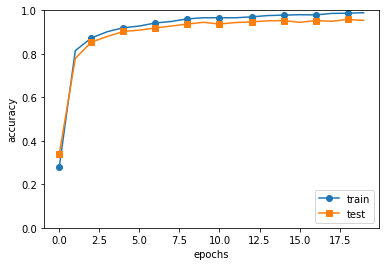

In [12]:
import sys, os
sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from simple_convnet import SimpleConvNet
from common.trainer import Trainer

# 데이터 읽기
(x_train, t_train), (x_test, t_test) = load_mnist(flatten=False)


# 시간이 오래 걸릴 경우 데이터를 줄인다.
x_train, t_train = x_train[:5000], t_train[:5000]
x_test, t_test = x_test[:1000], t_test[:1000]

max_epochs = 20

network = SimpleConvNet(input_dim=(1,28,28), 
                        conv_param = {'filter_num': 30, 'filter_size': 5, 'pad': 0, 'stride': 1},
                        hidden_size=100, output_size=10, weight_init_std=0.01)
                        
trainer = Trainer(network, x_train, t_train, x_test, t_test,
                  epochs=max_epochs, mini_batch_size=100,
                  optimizer='Adam', optimizer_param={'lr': 0.001},
                  evaluate_sample_num_per_epoch=1000)  # image = (100,1,28,28) , W = (30,1,5,5)
                                                       # out = (100,30,24,24)
                                                       # pout = (100,30,12,12)
                                                       # flatten = (100,30*12*12)=>(100,4320)
                                                       # W1 = (4320, 100)  => (100,100)
                                                       # W2 = (100, 10)  => (100,10)
trainer.train()

# 매개변수 보존
network.save_params("params.pkl")
print("Saved Network Parameters!")

# 그래프 그리기
markers = {'train': 'o', 'test': 's'}
x = np.arange(max_epochs)
plt.plot(x, trainer.train_acc_list, marker='o', label='train', markevery=2)
plt.plot(x, trainer.test_acc_list, marker='s', label='test', markevery=2)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

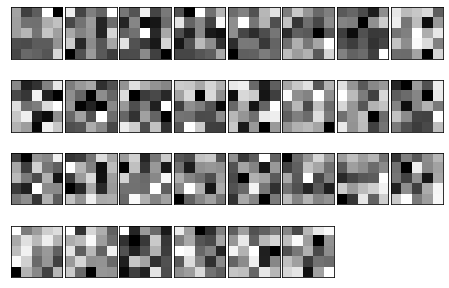

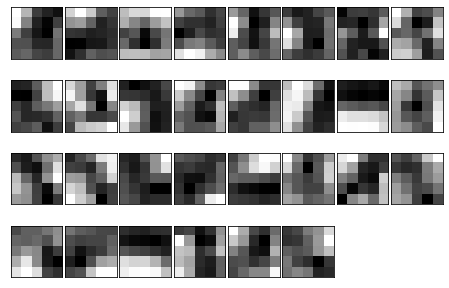

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from simple_convnet import SimpleConvNet

def filter_show(filters, nx=8, margin=3, scale=10):
    """
    c.f. https://gist.github.com/aidiary/07d530d5e08011832b12#file-draw_weight-py
    """
    FN, C, FH, FW = filters.shape
    ny = int(np.ceil(FN / nx))

    fig = plt.figure()
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

    for i in range(FN):
        ax = fig.add_subplot(ny, nx, i+1, xticks=[], yticks=[])
        ax.imshow(filters[i, 0], cmap=plt.cm.gray_r, interpolation='nearest')
    plt.show()


network = SimpleConvNet()
# 무작위(랜덤) 초기화 후의 가중치
filter_show(network.params['W1'])

# 학습된 가중치
network.load_params("params.pkl")
filter_show(network.params['W1'])